In [1]:
import cv2
import os.path
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras

In [3]:
#Function to create a table with path of all images (train images)
def paths(path, allowed_extension = 'jpg'):
    global Path
    images_dir = Path(path)
    filepaths = pd.Series((images_dir.glob(f'**/*.{allowed_extension}'))).astype(str)
    filepaths.name = 'path'
    return filepaths

#Function to create a table with labels of the respective images 
def labels(paths):
    labels = []
    for i in range(0, len(paths)):
        labels.append(paths[i].split('\\')[-2])
    labels = pd.Series(labels)
    labels.name = 'label'
    return labels

#Function to join these two, tables and shuffle the table after that resetting the index
def concat_and_shuffle(paths, labels):
    df = pd.concat([paths, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [3]:
#Running the above functions
path = paths('./data/asl-alphabet/asl_alphabet_train')
label = labels(path)
df = concat_and_shuffle(path, label)

In [4]:
df

,path,label
0,data\asl-alphabet\asl_alphabet_train\Z\Z2612.jpg,Z
1,data\asl-alphabet\asl_alphabet_train\G\G457.jpg,G
2,data\asl-alphabet\asl_alphabet_train\B\B271.jpg,B
3,data\asl-alphabet\asl_alphabet_train\del\del46...,del
4,data\asl-alphabet\asl_alphabet_train\A\A2540.jpg,A
...,...,...
86995,data\asl-alphabet\asl_alphabet_train\W\W1934.jpg,W
86996,data\asl-alphabet\asl_alphabet_train\G\G2368.jpg,G
86997,data\asl-alphabet\asl_alphabet_train\D\D1347.jpg,D
86998,data\asl-alphabet\asl_alphabet_train\P\P2592.jpg,P


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87000 entries, 0 to 86999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    87000 non-null  object
 1   label   87000 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [6]:
# Classes counts
counts = df.iloc[:,1].value_counts().sort_index()
print('Total number of classes =', len(counts))
print(f"Dataset size = {counts.sum()} samples", '\n')
print("Classes counts")
print(counts.head(counts.shape[0]))

Total number of classes = 29
Dataset size = 87000 samples 

Classes counts
A          3000
B          3000
C          3000
D          3000
E          3000
F          3000
G          3000
H          3000
I          3000
J          3000
K          3000
L          3000
M          3000
N          3000
O          3000
P          3000
Q          3000
R          3000
S          3000
T          3000
U          3000
V          3000
W          3000
X          3000
Y          3000
Z          3000
del        3000
nothing    3000
space      3000
Name: label, dtype: int64


In [6]:
trainGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input,
    validation_split = 0.2,
    horizontal_flip = True,
    brightness_range = (0.75, 1.3),
    zoom_range = 0.2
)

train_image = trainGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = 'path',
    y_col = 'label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 64,
    shuffle = True,
    subset = 'training'
)

val_image = trainGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = 'path',
    y_col = 'label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 64,
    shuffle = True,
    subset = 'validation'
)

Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.


In [7]:
def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    
def visualize(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()

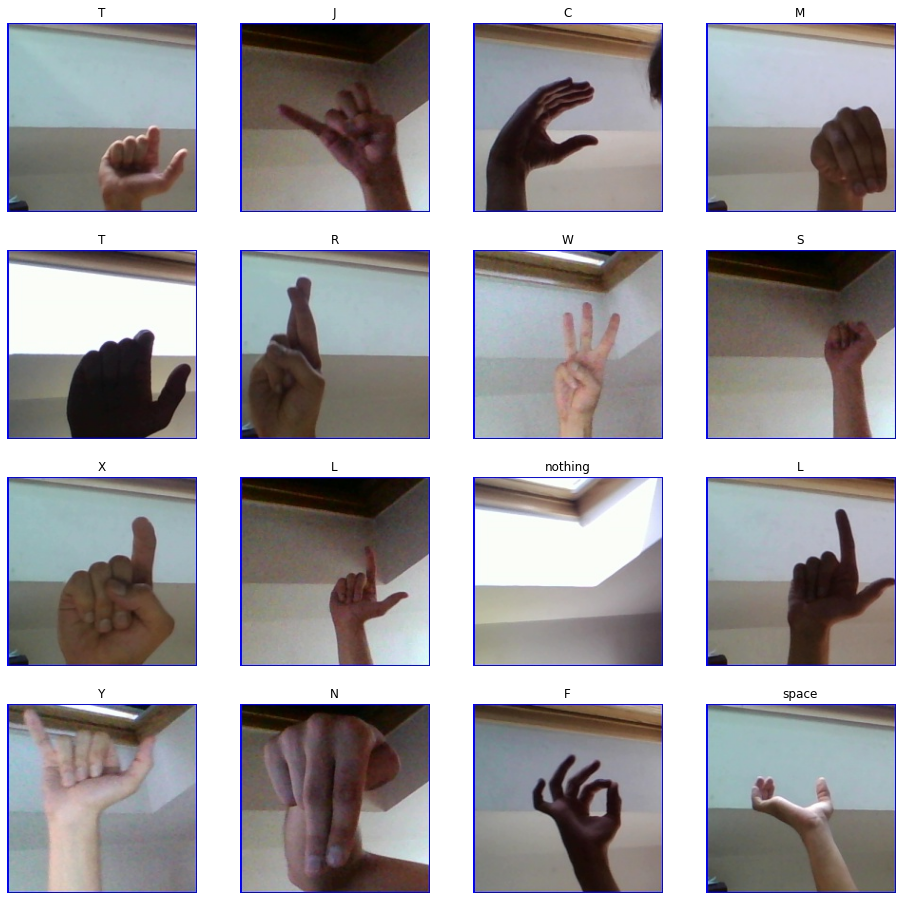

In [8]:
visualize(train_image)

In [7]:
pretrained = tf.keras.applications.MobileNet(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)

inputs = pretrained.input

x = tf.keras.layers.Dense(128, activation = 'relu')(pretrained.output)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)

In [10]:
model.layers

In [10]:
model.compile(
    optimizer = optimizer_adam,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [11]:
model.fit(
    train_image,
    validation_data = val_image,
    epochs = 2
)

Epoch 1/2
1088/1088 [==============================] - 5128s 5s/step - loss: 0.2997 - accuracy: 0.9052 - val_loss: 0.2944 - val_accuracy: 0.9170
Epoch 2/2
1088/1088 [==============================] - 4943s 5s/step - loss: 0.0753 - accuracy: 0.9788 - val_loss: 0.1347 - val_accuracy: 0.9657


In [12]:
model.save('Asl-Classifier2.h5')

In [32]:
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    global classes
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])
    
    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()

In [33]:
images[0].shape

(200, 200, 3)

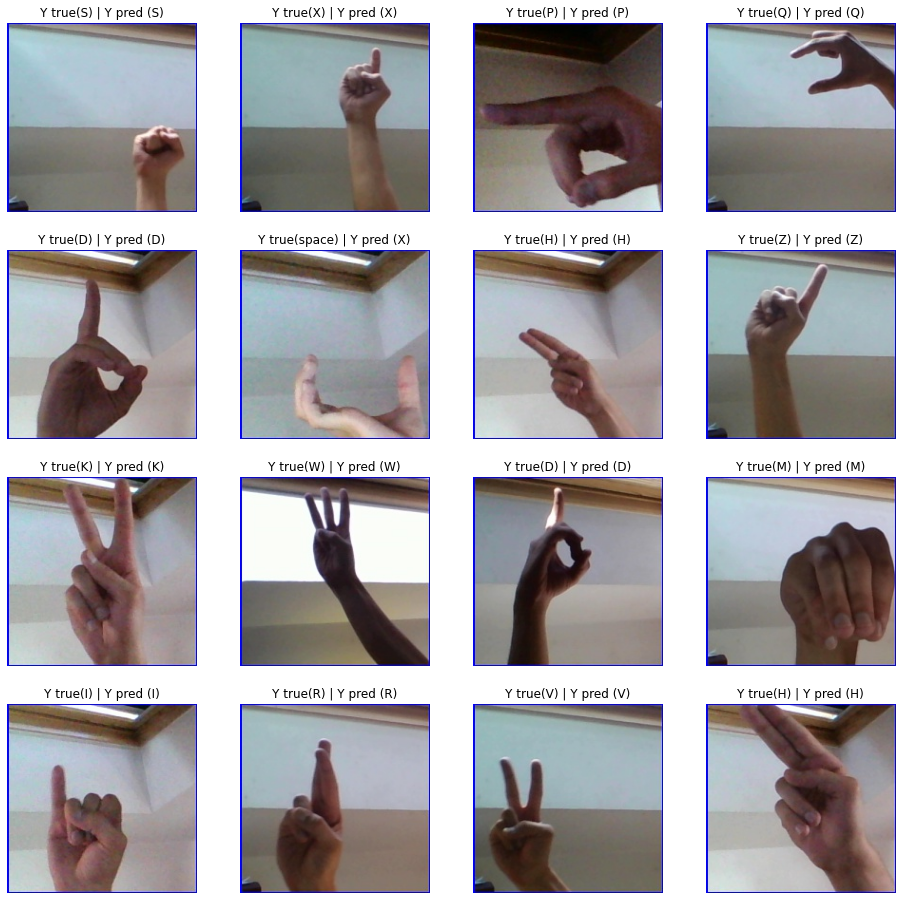

In [34]:
visualize_classifications(model, val_image)

In [39]:
img = get_image('./data/asl-alphabet/asl_alphabet_test/space_test.jpg')
img = process(img)
img.shape

(1, 224, 224, 3)

In [40]:
model.predict(img)

array([[6.8522109e-05, 2.8141122e-04, 8.3605082e-05, 1.5782751e-03,
        2.0036030e-06, 1.4042449e-05, 3.5673507e-05, 1.2915363e-04,
        2.5176725e-04, 5.9597282e-04, 9.6738111e-04, 1.0673966e-04,
        3.2834074e-04, 7.6991382e-05, 1.2204092e-03, 5.0091725e-03,
        1.4426114e-04, 5.9845753e-04, 1.8394530e-04, 2.9211669e-04,
        1.9386817e-02, 5.8547134e-04, 1.6138432e-04, 4.7463607e-03,
        1.4383103e-03, 1.2075388e-02, 5.1839817e-03, 2.6028047e-03,
        9.4185120e-01]], dtype=float32)

In [41]:
y_pred = classes[np.argmax(model.predict(img, verbose=0), axis=1)]
y_pred

array(['space'], dtype='<U7')

In [42]:
classes

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'del', 'nothing', 'space'], dtype='<U7')

In [43]:
classes1 = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
                       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
                       'del', 'nothing', 'space'])

In [46]:
y_pred = classes1[np.argmax(model.predict(img, verbose=0), axis=1)]
print(y_pred[0])

space


In [5]:
def getstates(inputImg, model):
    model = tf.keras.models.load_model(model)
    outputs = [layer.output for layer in model.layers[1:]]
    vis = tf.keras.Model(inputs = model.inputs, outputs = outputs, name = 'Visualization')
    if len(inputImg.shape) != 4:
        inputImg = tf.expand_dims(inputImg, 0)
    inputImg = inputImg / 255.0
    pred = vis.predict(inputImg)
    layernames = [layer.name for layer in model.layers[1:]]
    for layername, prediction in zip(layernames, pred):
        print(layername)
        if 'conv' in layername:
            n_features = prediction.shape[-1]
            size = prediction.shape[1]
            grid = np.zeros((size, n_features))
            for i in range(n_features):
                grid[:,i*size:(i+1)*size] = prediction[0,:,:,i]
            scale = 20.0 / n_features
            plt.figure(figsize = (scale*n_features, scale*2))
            plt.title(layername)
            plt.grid(False)
            plt.imshow(grid, aspect = auto, cmap = 'viridis')
        else:
            print('Error')

In [6]:
def visualize_interm_convs(input_image, model):
    model = tf.keras.models.load_model(model)
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = tf.keras.Model(inputs=model.input, outputs=successive_outputs, name='visualization_model')

    if len(input_image.shape) != 4:
        input_image = tf.expand_dims(input_image, 0)

        img = input_image / 255.0

        predictions = visualization_model.predict(img)

        layer_names = [layer.name for layer in model.layers[1:]]

        for layer_name, feature_map in zip(layer_names[:5], predictions[:5]):
            if len(feature_map.shape) == 4:
                n_features = feature_map.shape[-1]
                size = feature_map.shape[1]

                disp_grid = np.zeros((size, size * n_features))

                for i in range(n_features):
                    disp_grid[:, i * size:(i + 1) * size] = feature_map[0, :, :, i]


                scale = 20. / n_features
                plt.figure( figsize=(scale * n_features, scale * 2) )
                plt.title ( layer_name )
                plt.grid  ( False )
                plt.imshow( disp_grid, aspect='auto', cmap='viridis')

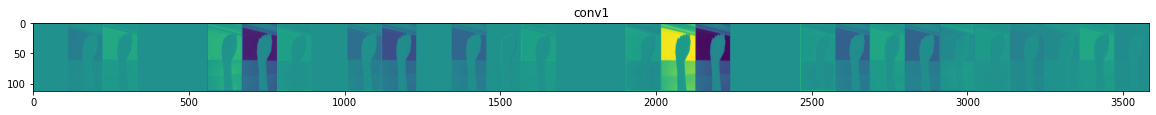

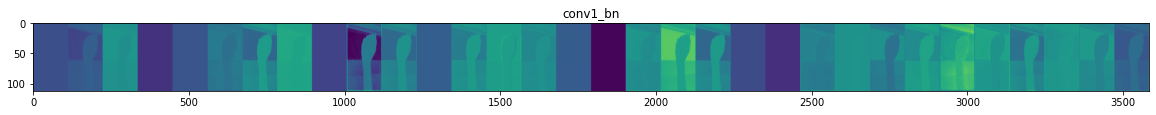

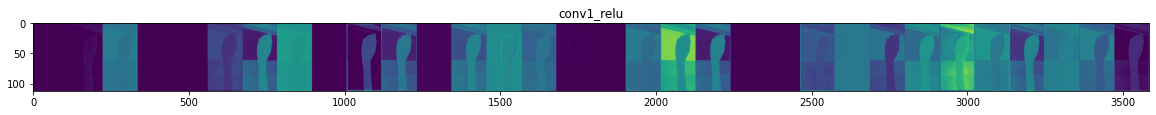

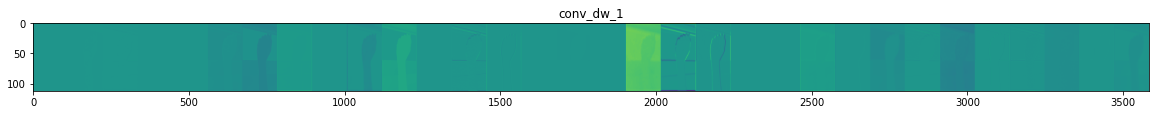

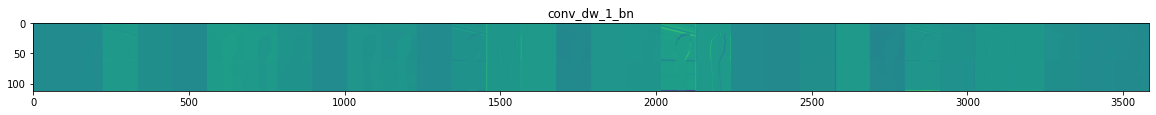

In [7]:
visualize_interm_convs(img, './Asl-Classifier2.h5')

In [3]:
img = cv2.imread('./data/asl-alphabet/asl_alphabet_test/A_test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = tf.cast(img, tf.float32)
img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[  1.,   1., 255.],
        [  0.,   0., 251.],
        [  1.,   0., 248.],
        ...,
        [  4.,   0., 242.],
        [  1.,   2., 245.],
        [  0.,   5., 249.]],

       [[  2.,   1., 252.],
        [  4.,   2., 241.],
        [  8.,   5., 221.],
        ...,
        [ 11.,   5., 206.],
        [  1.,   3., 216.],
        [  0.,   5., 224.]],

       [[  1.,   0., 244.],
        [  8.,   5., 220.],
        [ 49.,  44., 198.],
        ...,
        [ 90.,  83., 202.],
        [ 72.,  71., 226.],
        [  9.,  10., 183.]],

       ...,

       [[  3.,   0., 242.],
        [ 10.,   5., 207.],
        [ 51.,  49., 168.],
        ...,
        [130., 128., 181.],
        [108., 108., 215.],
        [ 12.,  14., 148.]],

       [[  1.,   0., 248.],
        [ 10.,   8., 226.],
        [ 39.,  37., 196.],
        ...,
        [107., 108., 215.],
        [ 84.,  88., 228.],
        [  8.,  15., 171.]],

       [[  2.,   

In [12]:
img = cv2.imread('./data/asl-alphabet/asl_alphabet_test/B_test.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
img = tf.cast(img, tf.float32)
img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[  0.,   5., 255.],
        [  0.,   2., 251.],
        [  3.,   0., 247.],
        ...,
        [  5.,   1., 249.],
        [  2.,   3., 252.],
        [  0.,   2., 250.]],

       [[  0.,   2., 252.],
        [  0.,   1., 239.],
        [  9.,   4., 221.],
        ...,
        [ 11.,   3., 208.],
        [  4.,   3., 219.],
        [  1.,   5., 226.]],

       [[  1.,   1., 247.],
        [  8.,   3., 219.],
        [ 29.,  19., 177.],
        ...,
        [139., 126., 234.],
        [110., 104., 233.],
        [ 12.,  11., 181.]],

       ...,

       [[  5.,   1., 248.],
        [  5.,   3., 206.],
        [ 99.,  98., 215.],
        ...,
        [140., 128., 192.],
        [116., 108., 222.],
        [ 17.,  11., 153.]],

       [[  0.,   0., 247.],
        [  5.,   6., 221.],
        [ 79.,  79., 233.],
        ...,
        [113., 104., 219.],
        [ 90.,  86., 231.],
        [ 12.,  10., 176.]],

       [[  0.,   

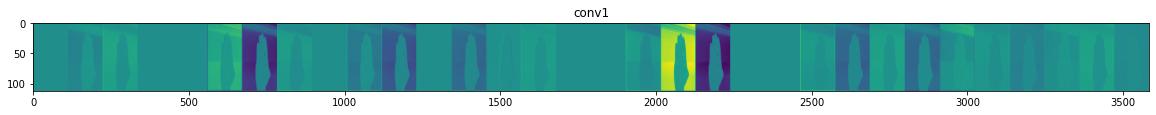

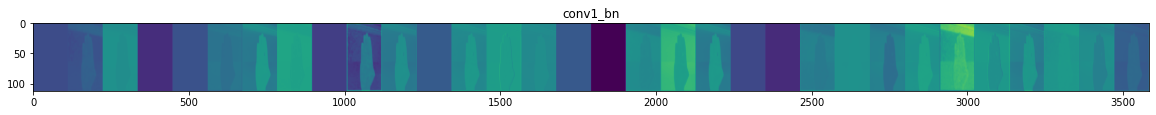

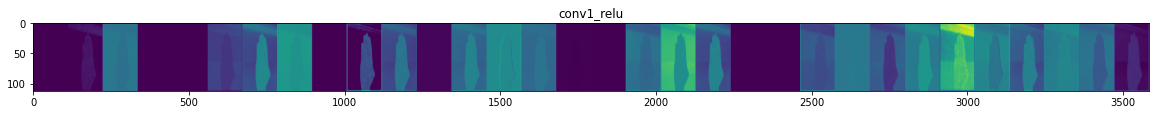

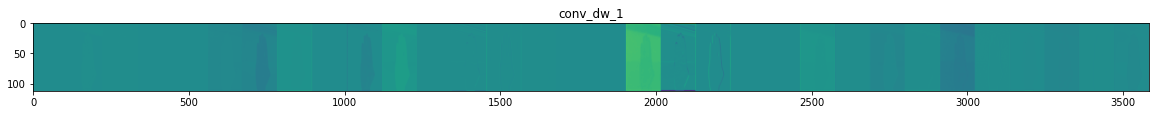

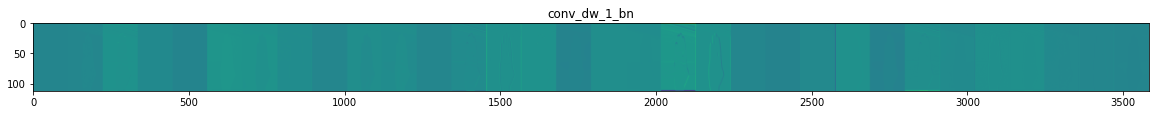

In [13]:
visualize_interm_convs(img, './Asl-Classifier2.h5')